## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ##
## [3. Balance the trainning set](#Balance) ##
## [4. Create train, test and validation generators](#generators) ##
## [5. Create a function to show Training Image Samples](#show) ##
## [6. Create the Model](#model) ##
## [7. Create a custom Keras callback to continue or halt training](#callback) ##
## [8. Instantiate custom callback ](#callbacks) ##
## [9. Train the model](#train) ##
## [10. Define a function to plot the training data](#plot) ##
## [11. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [12 Save the model](#save) ##
## [13 Plot Validation Loss % change between epochs](#implot) ##
## [14 Analysis of the Validation Loss % change plot](#analysis) ##

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/models/model_b7.h5
/kaggle/input/models/model_b3.h5
/kaggle/input/models/model_b5.h5
/kaggle/input/xceptionv2/model_v2.h5
/kaggle/input/durjoy-asd-dataset/face_crop.ipynb
/kaggle/input/durjoy-asd-dataset/averaging_predictor.ipynb
/kaggle/input/durjoy-asd-dataset/info.txt
/kaggle/input/durjoy-asd-dataset/classes.txt
/kaggle/input/durjoy-asd-dataset/.gitattributes
/kaggle/input/durjoy-asd-dataset/autism.ipynb
/kaggle/input/durjoy-asd-dataset/autism.csv
/kaggle/input/durjoy-asd-dataset/consolidated/autistic/1269.jpg
/kaggle/input/durjoy-asd-dataset/consolidated/autistic/623.jpg
/kaggle/input/durjoy-asd-dataset/consolidated/autistic/764.jpg
/kaggle/input/durjoy-asd-dataset/consolidated/autistic/1075.jpg
/kaggle/input/durjoy-asd-dataset/consolidated/autistic/771.jpg
/kaggle/input/durjoy-asd-dataset/consolidated/autistic/208.jpg
/kaggle/input/durjoy-asd-dataset/consolidated/autistic/820.jpg
/kaggle/input/durjoy-asd-dataset/consolidated/autistic/473.jpg
/kaggle/input/durjoy-asd-

<a id="import"></a>
# <center>Import Need Modules</center>

In [3]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

<a id="makedf"></a>
# <center>Read in train, test and valid images and create train, test and validation data frames</center>

In [4]:
def make_dataframes():
    print('Enter the full path to the directory containing the train, test and valid sub directories')
    sdir=input(' ')
    dataset_names= ['train', 'test' ,'valid']
    train_path=os.path.join(sdir, 'train')
    test_path=os.path.join(sdir, 'test')
    valid_path=os.path.join(sdir, 'valid')
    path_list=[train_path, test_path, valid_path]
    zip_list=zip(dataset_names, path_list)

    # generate train_df, test_df, valid_df
    for dataset, setpath in zip_list:
        filepaths=[]
        labels=[]
        classes=sorted(os.listdir(setpath))
        for klass in classes:
            classpath=os.path.join(setpath, klass)
            flist=sorted(os.listdir(classpath))
            desc=f'{dataset:6s}-{klass:13s}'
            for f in tqdm(flist, ncols=130, desc=desc):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if dataset =='train':
            train_df=df
        elif dataset == 'test':
            test_df=df
        else:
            valid_df=df
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)
    counts=list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count, sdir


In [5]:
train_df, test_df, valid_df, classes, class_count, sdir=make_dataframes()

Enter the full path to the directory containing the train, test and valid sub directories


  /kaggle/input/durjoy-asd-dataset


valid -non_autistic : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 166639.01it/s]


number of classes in processed dataset=  2
the maximum files in any class in train_df is  1263   the minimum files in any class in train_df is  1263
train_df length:  2526   test_df length:  200   valid_df length:  200
average image height=  319   average image width=  274  aspect ratio h/w=  1.1642335766423357


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [6]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    #trgen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20 )
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=50
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=20
img_size=(224,224)
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 2526 validated image filenames belonging to 2 classes.           for train generator 
Found 200 validated image filenames belonging to 2 classes.            for valid generator 
Found 200 validated image filenames belonging to 2 classes.            for test generator 
test batch size:  50   test steps:  4  number of classes :  2


write a text file to the sdir that contains the classes information. This file named classes.txt. It can be used in association with  
the averaging_predictor.ipynb notebook. That notebook needs to know the classes information to make predictions on image files

<a id="show"></a>
# <center>Create a function to show example training images</center>

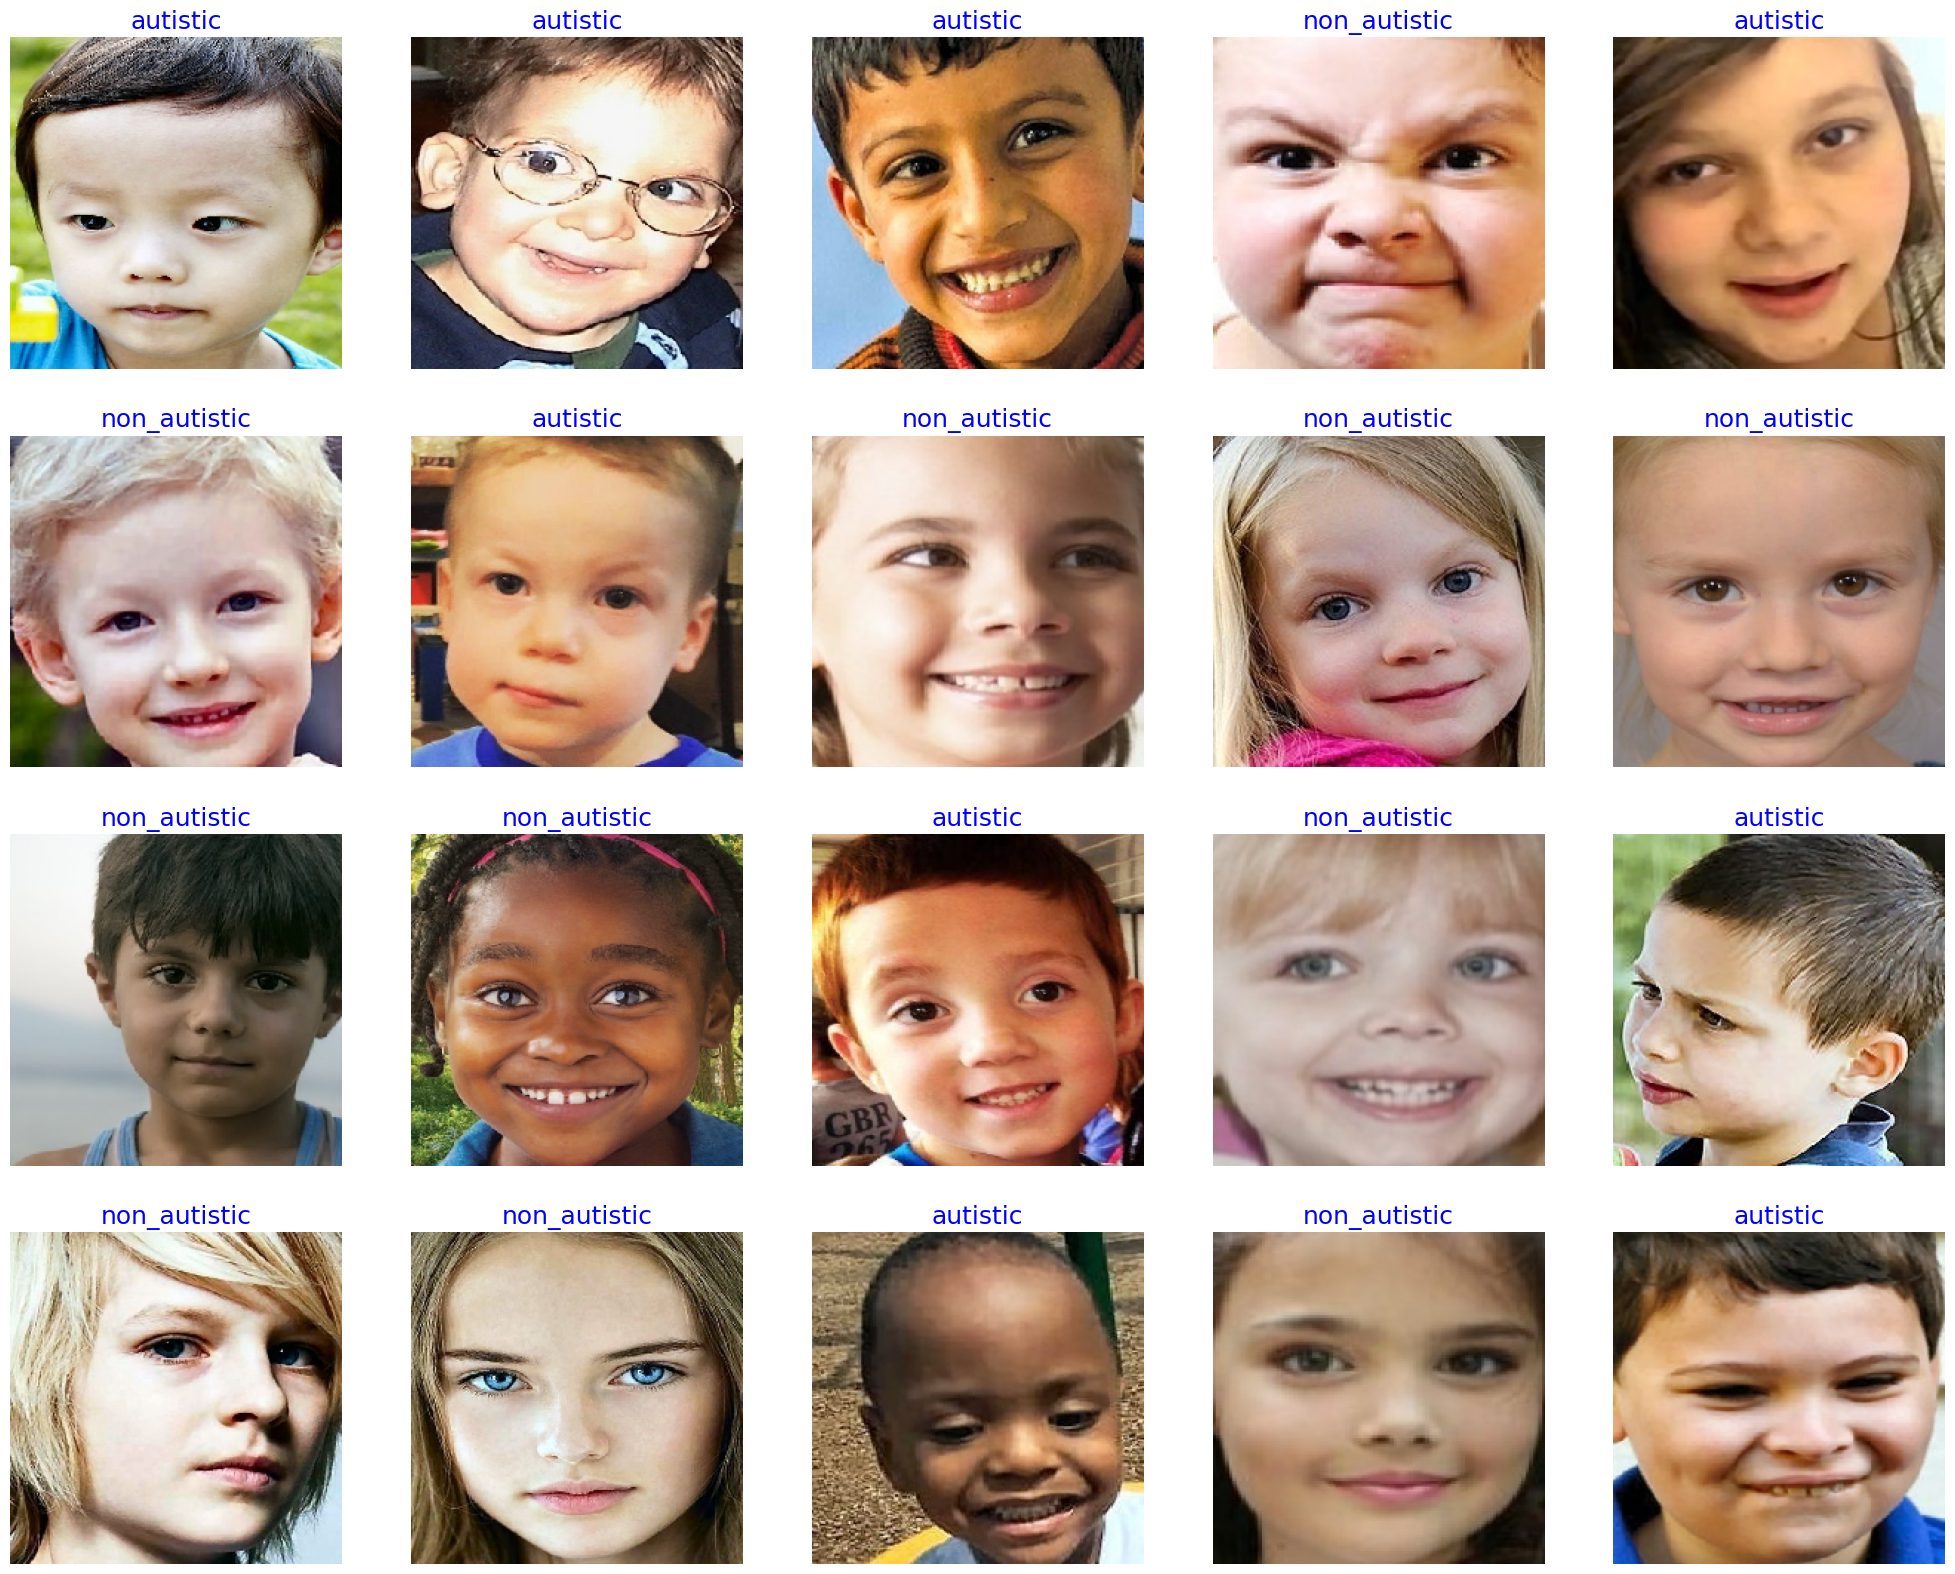

In [7]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB5</center>
### NOTE experts advise you make the base model initially not trainable when you do transfer learning.   
### Then train for some number of epochs then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs! Insure  you initialize the transfer model with imagenet weights

In [8]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Conv2D
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB5, EfficientNetB7
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


def build_efficientnet_b3(img_size, class_count):
    img_shape = (img_size[0], img_size[1], 3)

    # Build EfficientNet B3 model
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False, weights="imagenet", input_shape=img_shape, pooling=None
    )
    base_model.trainable = True

    # Common part of the model
    x = base_model.output
    x = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.4, seed=123)(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)

    # Build EfficientNet B3 branch
    output_efficientnet = Dense(class_count, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output_efficientnet)

    # Compile the model
    model.compile(optimizer=Adamax(learning_rate=0.002),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


def build_efficientnet_b7(img_size, class_count):
    img_shape = (img_size[0], img_size[1], 3)

    # Build EfficientNet B7 model
    base_model = tf.keras.applications.EfficientNetB7(
        include_top=False, weights="imagenet", input_shape=img_shape, pooling=None
    )
    base_model.trainable = True

    # Common part of the model
    x = base_model.output
    x = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.4, seed=123)(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    

    # Build EfficientNet B7 branch
    output_efficientnet = Dense(class_count, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output_efficientnet)

    # Compile the model
    model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


def build_efficientnet_b5(img_size, class_count):
    img_shape = (img_size[0], img_size[1], 3)

    base_model = EfficientNetB5(
        include_top=False, weights="imagenet", input_shape=img_shape, pooling=None
    )
    base_model.trainable = True

    x = base_model.output
    x = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.4, seed=123)(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    
    output = tf.keras.layers.Dense(class_count, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def build_voting_average_ensemble_model(img_size, class_count, train_gen, valid_gen, test_gen):
#     model_b3 = build_efficientnet_b3(img_size, class_count)
#     model_b5 = build_efficientnet_b5(img_size, class_count)
#     model_b7 = build_efficientnet_b7(img_size, class_count)

#     # Train the individual models
#     history_b3 = model_b3.fit(train_gen, epochs=12, validation_data=valid_gen)
#     history_b5 = model_b5.fit(train_gen, epochs=13, validation_data=valid_gen)
#     history_b7 = model_b7.fit(train_gen, epochs=12, validation_data=valid_gen)
    from tensorflow.keras.models import load_model
    model1_b3 = load_model('/kaggle/input/models/model_b3.h5')
#     model1_b5 = load_model('/kaggle/input/models/model_b5.h5')
    model1_b7 = load_model('/kaggle/input/models/model_b7.h5')
    model1_v2 = load_model('/kaggle/input/xceptionv2/model_v2.h5')

    # Predict probabilities using the trained models
    b3_preds = model1_b3.predict(test_gen)
#     b5_preds = model1_b5.predict(test_gen)
    b7_preds = model1_b7.predict(test_gen)
    v2_preds = model1_v2.predict(test_gen)

    # Perform voting by averaging the predicted probabilities
    ensemble_preds = (b3_preds + b7_preds + v2_preds) / 3.0

    # Make final predictions based on voting
    final_predictions = np.argmax(ensemble_preds, axis=1)

    # Calculate accuracy
    accuracy = np.mean(final_predictions == test_gen.labels)
    print(f"Ensemble Model Accuracy: {accuracy}")

    return final_predictions

    

# ... (rest of the code)

# Build the ensemble model
final_predictions = build_voting_average_ensemble_model(img_size, class_count, train_gen, valid_gen, test_gen)

# Get training histories of each model


4/4 [==============================] - 26s 6s/step
Ensemble Model Accuracy: 0.93


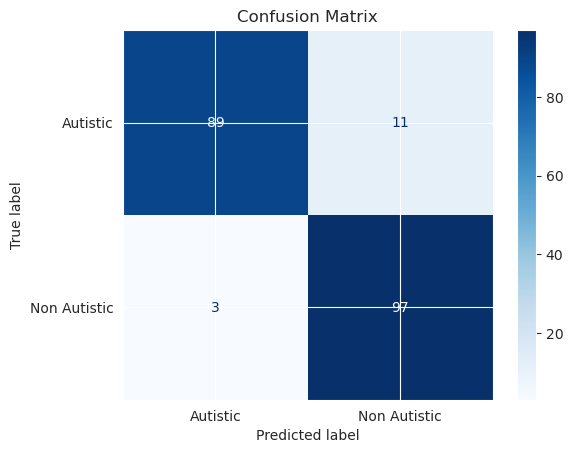

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'{title} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title(f'{title} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='.0f')
    plt.title("Confusion Matrix")
    plt.show()
    
    
# h_b3 = history_b3.history
# h_b5 = history_b5.history
# h_b7 = history_b7.history

# # Plot training and validation curves for each individual model
# plot_training_history(h_b3, 'EfficientNetB3')
# plot_training_history(h_b5, 'EfficientNetB5')
# plot_training_history(h_b7, 'EfficientNetB7')

# Plot confusion matrix for testing
class_names = ['Autistic', 'Non Autistic']  # Replace with your class names
plot_confusion_matrix(test_gen.labels, final_predictions, class_names)


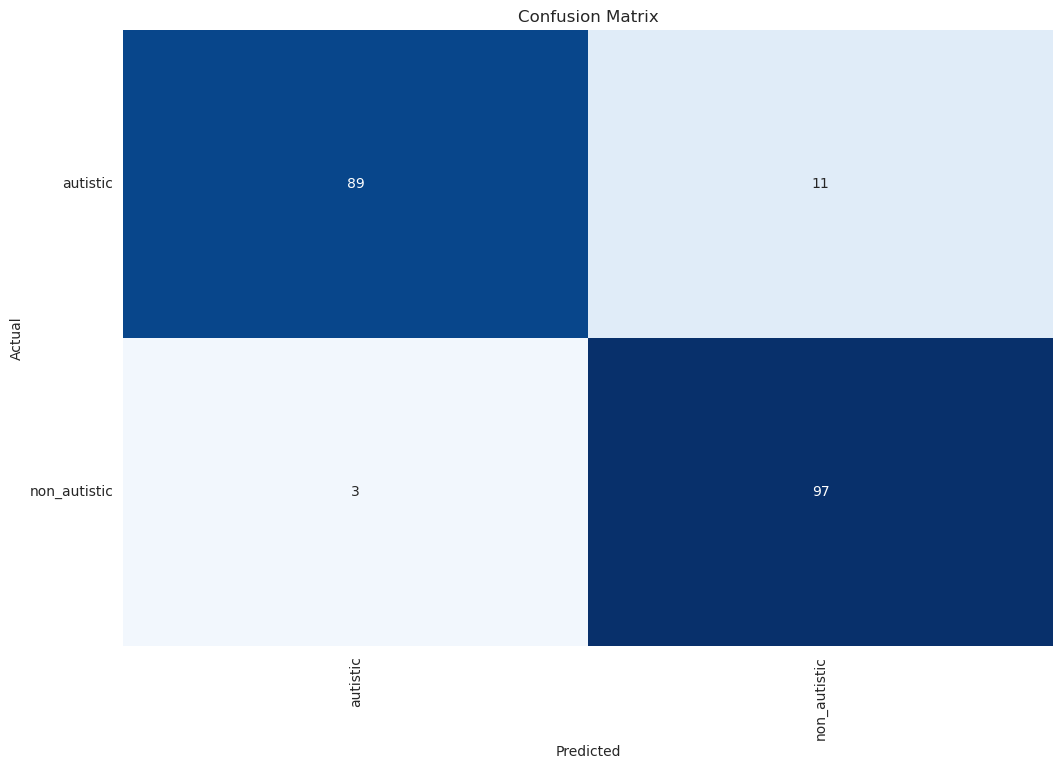

In [10]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
plot_confusion_matrix(test_gen.labels, final_predictions, class_names)

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming final_predictions are your predicted labels and test_gen.labels are the true labels
precision = precision_score(test_gen.labels, final_predictions)
recall = recall_score(test_gen.labels, final_predictions)
f1 = f1_score(test_gen.labels, final_predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Precision: 0.8981481481481481
Recall: 0.97
F1 Score: 0.9326923076923077


<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.
 * dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest   
   validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate  
   is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation  
   here is that if the validatio loss increased we have moved to a point in Nspace on the cost functiob surface that  
   if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights
   from the epoch with the lowest loss and the learning rate is reduced
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

<a id="callbacks"></a>
# <center>Instantiate custom callback

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset if you are doing transfer learning
### The model will converge faster and have a lower validation losss. Ensure you initialize the transfer model with imagenet weights.  
### I have done a lot of testing running both ways hand have alwats found this to be true

<a id="plot"></a>
# <center>Define a function to plot the training data

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

We achieved an F1 score of 83,6% which is not to bad considering we limited the number of images in train_df to 150  
images per class and reduced the image size to 200 X 282. This was done to reduce training time at the expense of the  
F1 score. Did model did better than I expected given that the labels for the images were probably done by a human or  
humans based on a visual rather than an analytic criteria.

<a id="save"></a>
# <center>Save the model